# Recommendation Systems Exhibition

In this notebook we will be examining different recommender systems built with PyTorch and see how they perform on the [MovieLens dataset](https://grouplens.org/datasets/movielens/).  Let's begin by importing the relevant packages.

In [1]:
# Import packages used throughout
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

from data import import_data
from methods import (utils, losses, matrix_factorization, AutoRec,
                     neural_collaborative_filtering, sequence_aware)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")


Using cuda


## Movielens Data

Let's now import the data with Pandas.  Here we have a long-form dataset of 100,000 ratings by 943 users on 1,682 movies.  The dataset includes associated timestamps.  Each user has rated at least 20 movies, but this is still a very sparse dataset.

In [2]:
# Import data
names = ["user_id", "item_id", "rating", "timestamp"]
data = pd.read_csv("data/u.data", delimiter='\t', names=names, engine="python")
num_users = data.user_id.unique().shape[0]
num_items = data.item_id.unique().shape[0]
data.head()


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


## Explicit Models

We begin by examining the simplest type of models -- explicit models.  Explicit models are given explicit ratings of the users (like in the Movielens dataset) and then try to predict a users' ratings for movies they haven't seen yet.

### Matrix Factorization

Matrix Factorization (MF) is the simplest explicit model.  In theory, MF decomposes the user x rating wide-matrix (943 x 1682) into two latent matrices with a hyperparameter that dictates the number of latent faetures.  Let's see how well this model performs.

In [3]:
# Obtain the data
num_users, num_items, train_iter, test_iter = import_data.split_and_load_ml100k(data,
                                                                                num_users, num_items, device, test_ratio=0.1, batch_size=512)


In [4]:
# Define evaluator
def evaluator(net, test_iter):
    rmse_list = []
    for _, (users, items, ratings) in enumerate(test_iter):
        r_hat = net(users, items)
        rmse_value = torch.sqrt(((r_hat - ratings)**2).mean())
        rmse_list.append(float(rmse_value))

    return np.mean(np.array(rmse_list))

In [5]:
# Prepare model
lr, num_epochs, wd = 0.002, 20, 1e-5

mf_net = matrix_factorization.MF(30, num_users, num_items).to(device)
optimizer = optim.Adam(mf_net.parameters(), lr = lr, weight_decay = wd)

In [6]:
# Train and evaluate model
rmse_list = []
loss_list = []
for epoch in range(num_epochs):
    total_loss, num_samples = 0, 0

    # Train each batch
    mf_net.train()
    for i, (users, items, ratings) in enumerate(train_iter):
        optimizer.zero_grad()

        predictions = mf_net(users, items)
        output = ((predictions - ratings)**2).mean()
        output.backward()
        optimizer.step()

        total_loss += output
        num_samples += users.shape[0]
    
    # Evaluate
    mf_net.eval()
    rmse = evaluator(mf_net, test_iter)
    rmse_list.append(rmse)
    loss_list.append(total_loss/num_samples)

    print(f"Epoch {epoch}:\n\tloss = {total_loss/num_samples}\n\trmse = {rmse}")

Epoch 0:
	loss = 0.018169919028878212
	rmse = 1.9636337757110596
Epoch 1:
	loss = 0.002767471596598625
	rmse = 1.22173011302948
Epoch 2:
	loss = 0.0019019551109522581
	rmse = 1.105634868144989
Epoch 3:
	loss = 0.0017740537878125906
	rmse = 1.074828028678894
Epoch 4:
	loss = 0.001731367316097021
	rmse = 1.0691817998886108
Epoch 5:
	loss = 0.0017118883552029729
	rmse = 1.0647526979446411
Epoch 6:
	loss = 0.0016952445730566978
	rmse = 1.0606454014778137
Epoch 7:
	loss = 0.001682286150753498
	rmse = 1.0571447610855103
Epoch 8:
	loss = 0.0016629884485155344
	rmse = 1.059793770313263
Epoch 9:
	loss = 0.0016440583858639002
	rmse = 1.0546758770942688
Epoch 10:
	loss = 0.0016190099995583296
	rmse = 1.0559799075126648
Epoch 11:
	loss = 0.0015907024499028921
	rmse = 1.0487103462219238
Epoch 12:
	loss = 0.0015594622818753123
	rmse = 1.0492611527442932
Epoch 13:
	loss = 0.0015303820837289095
	rmse = 1.050793468952179
Epoch 14:
	loss = 0.0015020002610981464
	rmse = 1.0507161617279053
Epoch 15:
	loss

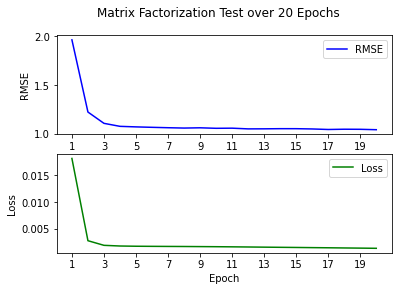

In [7]:
# Visualize
fig, ax = plt.subplots(2)
fig.suptitle(f"Matrix Factorization Test over {num_epochs} Epochs")

x_vals = list(range(1, num_epochs + 1))
ax[0].plot(x_vals, rmse_list, label = "RMSE", color = "blue")
ax[0].set_ylabel("RMSE")
ax[0].set_xticks(x_vals[::2])
ax[0].legend()

ax[1].plot(x_vals, loss_list, label = "Loss", color = "green")
ax[1].set_ylabel("Loss")
ax[1].set_xlabel("Epoch")
ax[1].set_xticks(x_vals[::2])
ax[1].legend()

As we can see, the root mean squared error became essentially 1 after 20 epochs.  This means that the average rating error of our model is about 1, which is not too bad given that the MF model only represents linear relationships.

### AutoRec

AutoRec is a model which has the same structure as an autoencoder which consists of an input layer, a hidden layer, and a reconstruction (output) layer.   Instead of explicitly embedding users/items into low-diemnsional space like a typical autoencoder does, AutoRec uses the column/row of the interaction matrix as the input and reconstructs the interaction matrix in the output layer.

In [8]:
# Obtain the data
train_data, test_data = import_data.split_data_ml100k(data, num_users, num_items)

_, _, _, train_inter_matrix = import_data.load_data_ml100k(train_data, num_users, num_items)
_, _, _, test_inter_matrix = import_data.load_data_ml100k(test_data, num_users, num_items)

train_inter_tensor = torch.from_numpy(train_inter_matrix).to(torch.float)
test_inter_tensor = torch.from_numpy(test_inter_matrix).to(torch.float)

train_iter = DataLoader(train_inter_tensor, shuffle = True, batch_size = 256,
    num_workers = 4)
test_iter = DataLoader(test_inter_tensor, shuffle = False, batch_size = 1024,
    num_workers = 4)

In [9]:
# Define evaluator
def evaluator(network, test_iter, device):
    rmse_list = []
    for _, users_ratings in enumerate(test_iter):
        users_ratings = users_ratings.to(device)
        recons = network(users_ratings)
        rmse_value = torch.sqrt(
            ((torch.sign(users_ratings) * recons - users_ratings)**2).mean())
        rmse_list.append(float(rmse_value))

    return np.mean(np.array(rmse_list))

In [10]:
# Prepare model
lr, num_epochs, wd = 0.002, 25, 1e-5

autorec_net = AutoRec(500, num_users).to(device)
optimizer = optim.Adam(autorec_net.parameters(), lr = lr, weight_decay=wd)

In [11]:
# Train and evaluate model
rmse_list = []
loss_list = []
for epoch in range(num_epochs):
    total_loss, num_samples = 0, 0

    # Train each batch
    autorec_net.train()
    for i, user_ratings in enumerate(train_iter):
        user_ratings = user_ratings.to(device)
        optimizer.zero_grad()

        predictions = autorec_net(user_ratings)
        output = ((predictions - user_ratings)**2).mean()
        output.backward()
        optimizer.step()

        total_loss += output
        num_samples += user_ratings.shape[0]
    
    # Evaluate
    autorec_net.eval()
    rmse = evaluator(autorec_net, test_iter, device)
    rmse_list.append(rmse)
    loss_list.append(total_loss/num_samples)

    print(f"Epoch {epoch}:\n\tloss = {total_loss/num_samples}\n\trmse = {rmse}")

Epoch 0:
	loss = 0.0019942375365644693
	rmse = 0.22753645479679108
Epoch 1:
	loss = 0.0011744025396183133
	rmse = 0.21421289443969727
Epoch 2:
	loss = 0.0007523800013586879
	rmse = 0.208097193390131
Epoch 3:
	loss = 0.0006033229292370379
	rmse = 0.2036922723054886
Epoch 4:
	loss = 0.0005152930971235037
	rmse = 0.2018025927245617
Epoch 5:
	loss = 0.0004091981681995094
	rmse = 0.1990256905555725
Epoch 6:
	loss = 0.0003851987421512604
	rmse = 0.20055443421006203
Epoch 7:
	loss = 0.0003375825472176075
	rmse = 0.19745052233338356
Epoch 8:
	loss = 0.00029480369994416833
	rmse = 0.19611306115984917
Epoch 9:
	loss = 0.0002717915049288422
	rmse = 0.1936339996755123
Epoch 10:
	loss = 0.0002460400282870978
	rmse = 0.1925877146422863
Epoch 11:
	loss = 0.00022956292377784848
	rmse = 0.18975723534822464
Epoch 12:
	loss = 0.0002133935922756791
	rmse = 0.18831483274698257
Epoch 13:
	loss = 0.00019999811775051057
	rmse = 0.18646708503365517
Epoch 14:
	loss = 0.00018984331109095365
	rmse = 0.18438600003

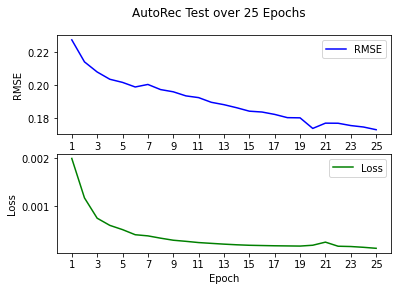

In [12]:
# Visualize
fig, ax = plt.subplots(2)
fig.suptitle(f"AutoRec Test over {num_epochs} Epochs")

x_vals = list(range(1, num_epochs + 1))
ax[0].plot(x_vals, rmse_list, label = "RMSE", color = "blue")
ax[0].set_ylabel("RMSE")
ax[0].set_xticks(x_vals[::2])
ax[0].legend()

ax[1].plot(x_vals, loss_list, label = "Loss", color = "green")
ax[1].set_ylabel("Loss")
ax[1].set_xlabel("Epoch")
ax[1].set_xticks(x_vals[::2])
ax[1].legend()

As we can see, the AutoRec model achieves a much lower RMSE than the MF model.  This is due to the multi-layer perceptrons of AutoRec which allow for non-linear relationships.

## Implicit Models

As nice as explicit models are, most data is not explicit but rather implicit, as explicit feedback can be expensive to collect.  Moreover, non-observed user-item pairs which may be predictive for users' interest are totally ignored.  For example, a user decides to never watch, let alone rates, a movie in a genre; that negative interaction is never recorded.  Implicit models solve this issue.  

Implicit, personalized models work by assiging a ranking of every movie in the space of movies.  They are given pairs of watched/unwatched movies and then their weights are optimized so that the watched movie is given a higher rank than the unwatched movie.  We assess the model using hit rate, where we count the number of actually watched movies within the top-k ranked movies determined by our model.

In [13]:
# Define metrics
def hit_and_auc(rankedlist, test_item, k):
    test_item = int(test_item)
    hits_k = test_item in rankedlist[:k]
    hits_all = [(idx, val) for idx, val in enumerate(rankedlist) if int(val) == test_item]

    max_num = len(rankedlist) - 1
    auc = 1.0 * (max_num - hits_all[0][0]) / \
        max_num if len(hits_all) > 0 else 0
    return hits_k, auc

## NeuMF

NeuMF works by essentally adding a feed-forward network alongside the MF model.  This feed-forward networks takes into user and movie embeddings and its output is concatenated with the MF model output to produce a final ranking.

In [14]:
# Prepare Dataset
batch_size = 1024
train_data, test_data = import_data.split_data_ml100k(data, num_users,
    num_items,'seq-aware')

# Training data
users_train, items_train, _, interactions = import_data.load_data_ml100k(
    train_data, num_users, num_items, feedback="implicit")
train_dataset = neural_collaborative_filtering.PRDataset(users_train, items_train, 
    interactions, num_items)
train_iter = DataLoader(train_dataset, batch_size = batch_size, shuffle = True,
    num_workers = 4)

# Test data
_, _, _, test_interactions = import_data.load_data_ml100k(test_data, num_users, num_items,
    feedback="implicit")

In [15]:
# Define evaluator
def evaluate_ranking_bpr(net, test_input, interactions, num_users, num_items, device):
    ranked_list, ranked_items, hit_rate, auc = {}, {}, [], []
    all_items = set([i for i in range(num_items)])
    for u in range(num_users):
        neg_items = list(all_items - set(interactions[u]))
        user_ids, item_ids, scores = [], [], []
        [item_ids.append(i) for i in neg_items]
        [user_ids.append(u) for _ in neg_items]
        test_dataset = TensorDataset(torch.from_numpy(np.array(user_ids)).to(device),    
            torch.from_numpy(np.array(item_ids)).to(device))
        test_data_iter = DataLoader(test_dataset, shuffle=False, batch_size=1024)

        for _, (user_idxs, item_idxs) in enumerate(test_data_iter):
            scores.extend(list(net(user_idxs, item_idxs).cpu().detach().numpy()))
        item_scores = list(zip(item_ids, scores))

        ranked_list[u] = sorted(item_scores, key=lambda t: t[1], reverse=True)
        ranked_items[u] = [r[0] for r in ranked_list[u]]
        
        temp = hit_and_auc(ranked_items[u], test_input[u][0], 50)
        hit_rate.append(temp[0])
        auc.append(temp[1])
    return np.mean(np.array(hit_rate)), np.mean(np.array(auc))

In [16]:
# Define weight initializer
def weights_init(module):
    if isinstance(module, nn.Embedding) or isinstance(module, nn.Linear):
        nn.init.normal_(module.weight, std=0.01)

In [17]:
# Create and initialize model
lr, num_epochs, wd = 0.01, 10, 1e-5

neuMF_net = neural_collaborative_filtering.NeuMF(10, num_users, num_items,
    nums_hiddens=[10, 10, 10]).to(device)
neuMF_net.apply(weights_init)
loss = losses.BPR_Loss
optimizer = optim.Adam(neuMF_net.parameters(), lr = lr, weight_decay=wd)

In [18]:
# Train and evaluate the model
hit_rate_list = []
auc_list = []
for epoch in range(num_epochs):
    accumulator, l = utils.Accumulator(2), 0.

    # Train each batch
    neuMF_net.train()
    for i, (user_idxs, item_idxs, neg_items) in enumerate(train_iter):
        user_idxs = user_idxs.to(device)
        item_idxs = item_idxs.to(device)
        neg_items = neg_items.to(device)

        optimizer.zero_grad()

        p_pos = neuMF_net(user_idxs, item_idxs)
        p_neg = neuMF_net(user_idxs, neg_items)

        total_loss = loss(p_pos, p_neg)
        total_loss.backward()
        optimizer.step()
        accumulator.add(total_loss, user_idxs.shape[0])

    # Evaluate
    neuMF_net.eval()
    hit_rate, auc = evaluate_ranking_bpr(neuMF_net, test_interactions, interactions, 
        num_users, num_items, device)
    hit_rate_list.append(hit_rate)
    auc_list.append(auc)

    print(f"Epoch {epoch}:\n\tloss = {accumulator[0]/accumulator[1]}\n\thit_rate = {hit_rate}\n\tauc = {auc}")

Epoch 0:
	loss = 0.561198788535854
	hit_rate = 0.17709437963944857
	auc = 0.7871646772782862
Epoch 1:
	loss = 0.49769583119746946
	hit_rate = 0.21527041357370094
	auc = 0.7923754525024231
Epoch 2:
	loss = 0.4733954203889751
	hit_rate = 0.23329798515376457
	auc = 0.8332217218669501
Epoch 3:
	loss = 0.4480687326681032
	hit_rate = 0.24072110286320256
	auc = 0.8474836960750556
Epoch 4:
	loss = 0.43640358413826763
	hit_rate = 0.2651113467656416
	auc = 0.853525638430526
Epoch 5:
	loss = 0.4296131840886513
	hit_rate = 0.26935312831389185
	auc = 0.8549238433940106
Epoch 6:
	loss = 0.4263512950191596
	hit_rate = 0.2608695652173913
	auc = 0.8565202516907026
Epoch 7:
	loss = 0.4217615310005185
	hit_rate = 0.2757158006362672
	auc = 0.8560132503834057
Epoch 8:
	loss = 0.41931713698112655
	hit_rate = 0.2767762460233298
	auc = 0.8551741886039541
Epoch 9:
	loss = 0.4168443203343072
	hit_rate = 0.2831389183457052
	auc = 0.8556609439001606


(0.0, 1.0)

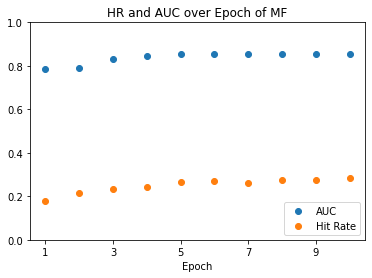

In [19]:
# Visualize
x = list(range(1, num_epochs + 1))
plt.scatter(x, auc_list, label = "AUC")
plt.scatter(x, hit_rate_list, label = "Hit Rate")
plt.title("HR and AUC over Epoch of MF")
plt.xlabel("Epoch")
plt.legend(loc = "lower right")
plt.xticks(x[0::2])
plt.ylim((0, 1))

As we can see, the model is able to attain an AUC of about 86% and a hit rate of 0.28, meaning that, on average, a little over a quarter of all the movies actually watched by user are in the top 50 rankings.  This is pretty good considering that we're considering only implicit information.

## Caser

One whole aspect of the data we have not inclued in our models is the timestamp.  Temporality means a lot when it comes to personalized recommendations, as movies that a user has recently watched are more likely to be relevant to what the user wants to watch in the future.  Consequently, we want a model that is ware of the sequence of movies that the user has watched in the past.  Caser is a model that does just that.

Caser looks at the sequence embeddings of movies for a particular user and then runs two convolutional neural networks over these embeddings: one focusing on the short term and another on the long term.  Thhe output of the convolutions are concatenated and then combined with general user and movie embeddings to produce a final rating.

In [20]:
# Prepare Dataset
TARGET_NUM, L, batch_size = 1, 5, 4096
train_data, test_data = import_data.split_data_ml100k(data, num_users, num_items,
                                                        'seq-aware')

# Training Data
users_train, items_train, _, candidates = import_data.load_data_ml100k(
    train_data, num_users, num_items, feedback="implicit")
train_seq_data = sequence_aware.SeqDataset(users_train, items_train, L, num_users,
                                            num_items, candidates)
train_iter = DataLoader(train_seq_data, batch_size=batch_size, shuffle=True, num_workers=4)

# Test Data
_, _, _, test_iter = import_data.load_data_ml100k(
    test_data, num_users, num_items, feedback="implicit")
test_seq_iter = train_seq_data.test_seq

In [21]:
# Define evaluator
def evaluate_ranking_bpr(net, test_input, test_seq_iter, interactions, num_users, num_items, device):
    ranked_list, ranked_items, hit_rate, auc = {}, {}, [], []
    all_items = set([i for i in range(num_items)])
    for u in range(num_users):
        neg_items = list(all_items - set(interactions[u]))
        user_ids, item_ids, scores = [], [], []
        [item_ids.append(i) for i in neg_items]
        [user_ids.append(u) for _ in neg_items]
        test_dataset = TensorDataset(torch.from_numpy(np.array(user_ids)).type(torch.long).to(device),
                                    torch.from_numpy(np.array(item_ids)).type(torch.long).to(device),
                                    torch.from_numpy(np.array(test_seq_iter[user_ids, :])).type(torch.long).to(device))
        test_data_iter = DataLoader(
            test_dataset, shuffle=False, batch_size=1024)

        for _, (user_idxs, item_idxs, seq) in enumerate(test_data_iter):
            scores.extend(
                list(net(user_idxs, seq, item_idxs).cpu().detach().numpy()))
        item_scores = list(zip(item_ids, scores))

        ranked_list[u] = sorted(
            item_scores, key=lambda t: t[1], reverse=True)
        ranked_items[u] = [r[0] for r in ranked_list[u]]

        temp = hit_and_auc(ranked_items[u], test_input[u][0], 50)
        hit_rate.append(temp[0])
        auc.append(temp[1])
    return np.mean(np.array(hit_rate)), np.mean(np.array(auc))

In [22]:
# Weight initializer
def weights_init(module):
    if (isinstance(module, nn.Embedding) or isinstance(module, nn.Linear)
            or isinstance(module, nn.Conv2d)):
        nn.init.normal_(module.weight, std=0.01)

In [23]:
# Create and initialize model
lr, num_epochs, wd = 0.04, 10, 1e-5

caser_net = sequence_aware.Caser(10, num_users, num_items, L).to(device)
caser_net.apply(weights_init)
loss = losses.BPR_Loss
optimizer = optim.Adam(caser_net.parameters(), lr = lr, weight_decay=wd)

In [24]:
# Train and evaluate the model
hit_rate_list = []
auc_list = []
for epoch in range(num_epochs):
    accumulator, l = utils.Accumulator(2), 0.

    # Train each batch
    caser_net.train()
    for i, (user_idxs, seq, pos_tgts, neg_tgts) in enumerate(train_iter):
        user_idxs = user_idxs.to(device)
        seq = seq.to(device)
        pos_tgts = pos_tgts.to(device)
        neg_tgts = neg_tgts.to(device)

        optimizer.zero_grad()

        user_idxs = user_idxs.type(torch.long)
        seq = seq.type(torch.long)
        pos_tgts = pos_tgts.type(torch.long)
        neg_tgts = neg_tgts.type(torch.long)

        p_pos = caser_net(user_idxs, seq, pos_tgts)
        p_neg = caser_net(user_idxs, seq, neg_tgts)

        total_loss = loss(p_pos, p_neg)
        total_loss.backward()
        optimizer.step()
        accumulator.add(total_loss, user_idxs.shape[0])

    # Evaluate
    caser_net.eval()
    hit_rate, auc = evaluate_ranking_bpr(
        caser_net, test_iter, test_seq_iter, candidates, num_users, num_items, device)
    hit_rate_list.append(hit_rate)
    auc_list.append(auc)

    print(
        f"Epoch {epoch}:\n\tloss = {accumulator[0]/accumulator[1]}\n\thit_rate = {hit_rate}\n\tauc = {auc}")

Epoch 0:
	loss = 0.4079925399792889
	hit_rate = 0.2142099681866384
	auc = 0.7964767616357551
Epoch 1:
	loss = 0.2707132270455383
	hit_rate = 0.28207847295864263
	auc = 0.8469149245419437
Epoch 2:
	loss = 0.20108196628280478
	hit_rate = 0.32237539766702017
	auc = 0.8708764258317736
Epoch 3:
	loss = 0.170591461461611
	hit_rate = 0.3361611876988335
	auc = 0.8790937801793068
Epoch 4:
	loss = 0.1513466928527383
	hit_rate = 0.33828207847295866
	auc = 0.8768211093812579
Epoch 5:
	loss = 0.14207745522323215
	hit_rate = 0.3552492046659597
	auc = 0.8810600339855864
Epoch 6:
	loss = 0.1372384129394213
	hit_rate = 0.3679745493107105
	auc = 0.883453070836951
Epoch 7:
	loss = 0.1300263754101535
	hit_rate = 0.36267232237539765
	auc = 0.8835089573348318
Epoch 8:
	loss = 0.12335572939529026
	hit_rate = 0.3796394485683987
	auc = 0.8882849732705369
Epoch 9:
	loss = 0.12113047334520158
	hit_rate = 0.38918345705196183
	auc = 0.8893322056865931


(0.0, 1.0)

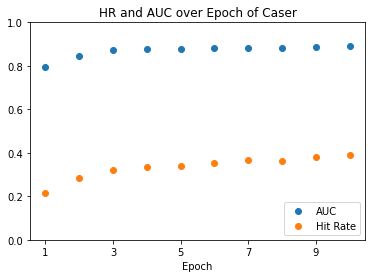

In [25]:
# Visualize
x = list(range(1, num_epochs + 1))
plt.scatter(x, auc_list, label = "AUC")
plt.scatter(x, hit_rate_list, label = "Hit Rate")
plt.title("HR and AUC over Epoch of Caser")
plt.xlabel("Epoch")
plt.legend(loc = "lower right")
plt.xticks(x[0::2])
plt.ylim((0, 1))

As we can see, the Caser model achieves significantly better metrics than NeuMF, thereby illustrating the importance of incoporating temporality into a recommendation system.

In this exhibition we looked a four different recommendation systems. Starting with explicit models that predict actual ratings, MF was shown to be lighting fast but not the most accurate, while AutoRec faired much better due to its incorporation of nonlinearity.  We then moved on to implicit models that predict overall rankings of movies based on implict watched/not-watched information.  Here, NeuMF was shown to be quite good but not the most accurate due to the muddy implicit information.  Caser made up for this deficiency in meaningfulness by incorporating the timestamp information into its architecture, pushing the AUC and hitrate metrics up even higher.